# 0.0 IMPORTS

In [96]:
import pandas                as pd
import seaborn               as sb
import numpy                 as np
import matplotlib.pyplot     as plt

import inflection

from scipy                   import stats        as ss
from collections             import Counter
from tabulate                import tabulate
from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm             import SVC
from xgboost                 import XGBClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics         import confusion_matrix, accuracy_score, classification_report, f1_score, cohen_kappa_score, roc_auc_score
from boruta                  import BorutaPy
from imblearn.over_sampling  import SMOTE

from IPython.display         import Image
from IPython.display         import HTML

## 0.1 Helper Functions

In [118]:
def jupyter_settings():
  
    %matplotlib inline
    %pylab inline
  
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width: 100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:.4f}'.format
    pd.set_option( 'display.expand_frame_repr', False )
  
    sb.set()
    
def exited_ratio(df):
    df['Exited Ratio'] = df.apply(lambda x: round(x['Exited']/(x['Renewed'] + x['Exited']), 3), axis=1)
    return df

def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).to_numpy()
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - ( k-1 ) * ( r-1 ) / ( n-1 ) )
    
    kcorr = k - ( k-1 )**2 / ( n-1 )
    rcorr = r - ( r-1 )**2 / ( n-1 )
    

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )

def algorithm_performance(model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    
    confusion_mat = confusion_matrix(y_test,y_pred)
    
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    specificity = confusion_mat[0][0] / (confusion_mat[0][0] + confusion_mat[0][1])
    sensitivity = confusion_mat[1][1] / (confusion_mat[1][0] + confusion_mat[1][1])
    
    plt.figure(figsize=(8,6))
    ax = plt.subplot()
    sb.heatmap(confusion_mat, annot=True, fmt='.0f', ax = ax, cmap='Greens', cbar=False);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1'])   
    ax.yaxis.set_ticklabels(['0', '1'])
    
    return pd.DataFrame({'Accuracy': np.round(accuracy, 3), 
                         'Sensitivity': np.round(sensitivity, 3), 
                         'Specificity': np.round(specificity, 3),
                         'F1': np.round(f1, 3),
                         'ROC_AUC': np.round(roc, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])

def filter_columns_in_numpy(np_matrix, columns_boruta):
    final_np_matrix = []
    
    cols_dict = {
        'credit_score': 0,
        'geography': 1,
        'gender': 2,
        'age': 3,
        'tenure': 4, 
        'balance': 5,
        'num_of_products': 6,
        'has_cr_card': 7,
        'is_active_member': 8,
        'estimated_salary': 9,
        'products_buyed_per_year': 10
    }

    indexes_to_filter = []
    for column in columns_boruta:
        indexes_to_filter.append(cols_dict[column])
    
    for array in np_matrix:
        final_np_matrix.append(array[indexes_to_filter])
    return final_np_matrix

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('data/churn.csv')
df_raw = df_raw.drop(['RowNumber'], axis=1)

# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
old_columns = df1.columns

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map(snakecase, old_columns) )

#rename
df1.columns = new_columns

## 1.2 Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 10000
Number of columns: 13


## 1.3 Data Types

In [8]:
df1.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Descriptive Statistical

In [10]:
# select numerical columns
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# select categorical columns
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1 Numerical Attributes

In [11]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] )

In [12]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,15565701.0000,15815690.0000,249989.0000,15690940.5694,15690738.0000,71932.5892,0.0011,-1.1961
1,credit_score,350.0000,850.0000,500.0000,650.5288,652.0000,96.6485,-0.0716,-0.4257
2,age,18.0000,92.0000,74.0000,38.9218,37.0000,10.4873,1.0113,1.3953
3,tenure,0.0000,10.0000,10.0000,5.0128,5.0000,2.8920,0.0110,-1.1652
4,balance,0.0000,250898.0900,250898.0900,76485.8893,97198.5400,62394.2853,-0.1411,-1.4894
5,num_of_products,1.0000,4.0000,3.0000,1.5302,1.0000,0.5816,0.7456,0.5830
6,has_cr_card,0.0000,1.0000,1.0000,0.7055,1.0000,0.4558,-0.9018,-1.1870
7,is_active_member,0.0000,1.0000,1.0000,0.5151,1.0000,0.4998,-0.0604,-1.9967
8,estimated_salary,11.5800,199992.4800,199980.9000,100090.2399,100193.9150,57507.6172,0.0021,-1.1815
9,exited,0.0000,1.0000,1.0000,0.2037,0.0000,0.4027,1.4716,0.1657


### 1.5.2 Categorial Attributes

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

In [14]:
# Country Distribution
df1[['geography', 'exited']].groupby('geography').count()

,exited
geography,
France,5014
Germany,2509
Spain,2477


In [15]:
# Gender Distribution
df1[['gender', 'exited']].groupby('gender').count()

,exited
gender,
Female,4543
Male,5457


### 1.5.3 Class Distribution

In [16]:
y = df1['exited'].values
counter = Counter(y)
for k, v in counter.items():
    dist = v / len(y) * 100
    print(f'Class={k}, n={v} ({round(dist,2)})%')

Class=1, n=2037 (20.37)%
Class=0, n=7963 (79.63)%


# 2.0 FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

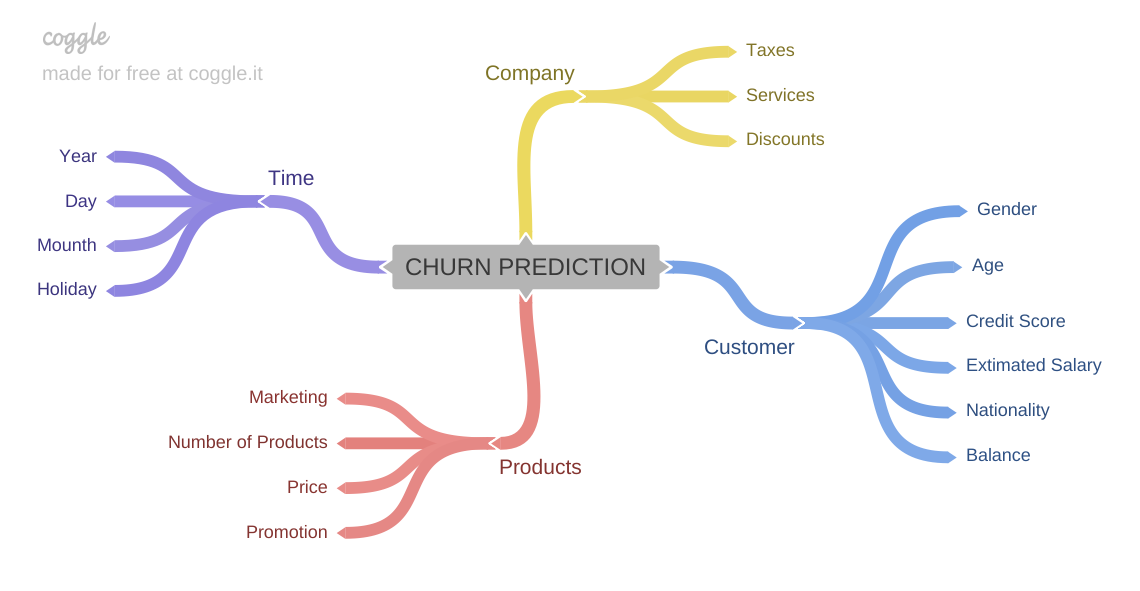

In [18]:
Image('img/mind_map_hypothesis.png')

### 2.1.1 Customer Hypothesis

**1.** Clientes com mais de 50 anos sempre renovam o contrato.

**2.** Clientes com salário acima da média deveriam renovar o contrato.

**3.** Clientes com "Credit Score" acima da média deveriam renovar o contrato.

**4.** Clientes com balanço acima da média deveriam renovar o contrato.

**5.** Clientes com cartão de crédito deveriam renovar o contrato.

### 2.1.2 Products Hypothesis

**1.** Clientes que utilizam serviços com menores taxas renovam o contrato.

**2.** Clientes que compram mais produtos renovam o contrato.

**3.** Clientes que compram produtos com menores preços renovam o contrato.

**4.** Clientes que utilizam mais os serviços renovam o contrato.

### 2.1.3 Time Hypothesis

**1.** Clientes que permaneceram ativo por mais tempo tendem a renovar o contrato.

**2.** Clientes que movimentaram a conta nos últimos 12 meses tendem a renovar o contrato.

**3.** Clientes que compram pelo menos 3 vezes no ano tendem a renovar o contrato.

### 2.1.4 Company Hypothesis

**1.** Serviços com maiores taxas fazem o cliente cancelar o contrato.

**2.** Descontos extendidos fazem o cliente renovar o contrato.

## 2.2 Final Hypothesis List

**1.** Clientes com mais de 50 anos sempre renovam o contrato.

**2.** Clientes com salário acima da média deveriam renovar o contrato.

**3.** Clientes com "Credit Score" acima da média deveriam renovar o contrato.

**4.** Clientes com balanço acima da média deveriam renovar o contrato.

**5.** Clientes com cartão de crédito deveriam renovar o contrato.

**6.** Clientes que compram mais produtos renovam o contrato.

**7.** Clientes que permaneceram ativo por mais tempo tendem a renovar o contrato.

**8.** Clientes que movimentaram a conta nos últimos 12 meses tendem a renovar o contrato.

**9.** Clientes que compram pelo menos 3 vezes no ano tendem a renovar o contrato.

## 2.3 Feature Engineering

In [19]:
df2['products_buyed_per_year'] = df2.apply(lambda x: 0 if x['tenure'] == 0 else x['num_of_products']/x['tenure'], axis=1)

# 3.0 FILTERING VARIABLES

In [20]:
df3 = df2.copy()

## 3.1 Columns Selection

In [21]:
df3.drop(columns=['customer_id','surname'], axis=1, inplace=True)

# 4.0 EXPLORATORY DATA ANALYSIS

In [22]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

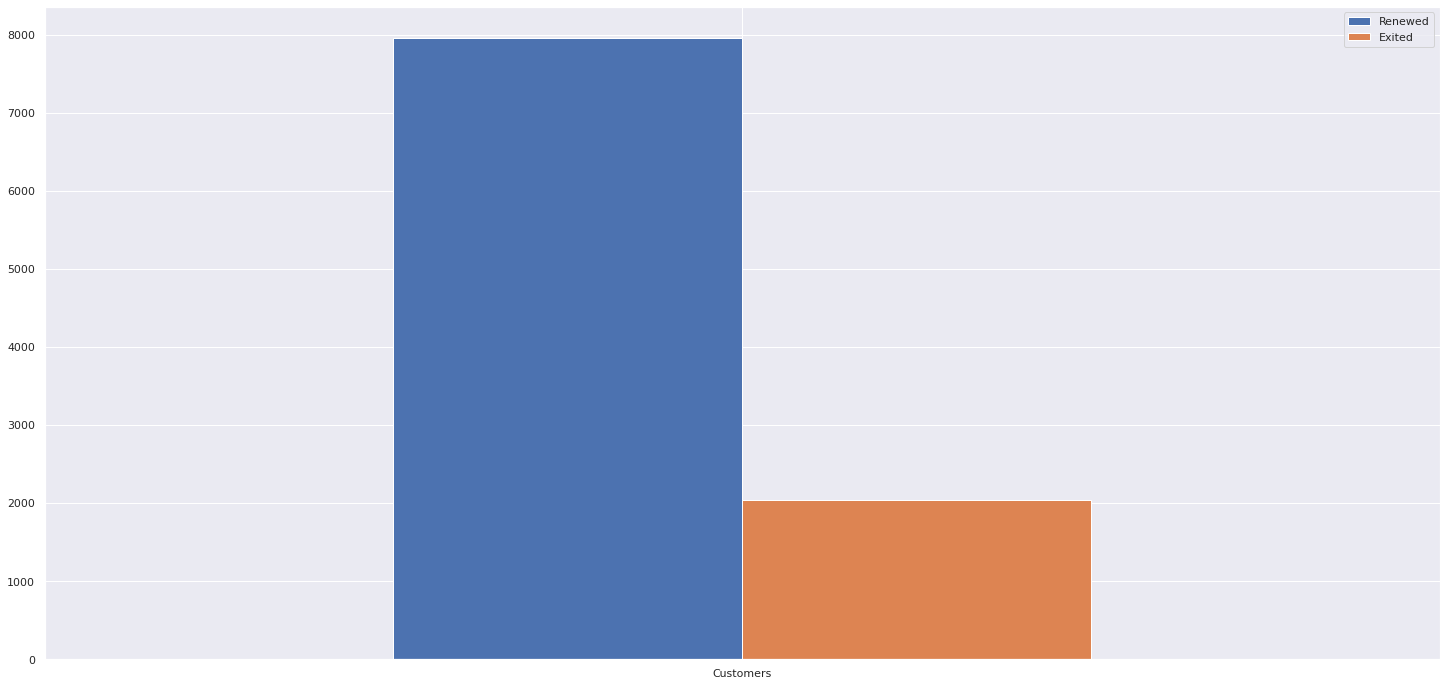

In [23]:
series = df4['exited'].value_counts()

aux1 = pd.DataFrame({'Customers': series}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux1.plot.bar(rot=0);

### 4.1.2 Numerical Attributes

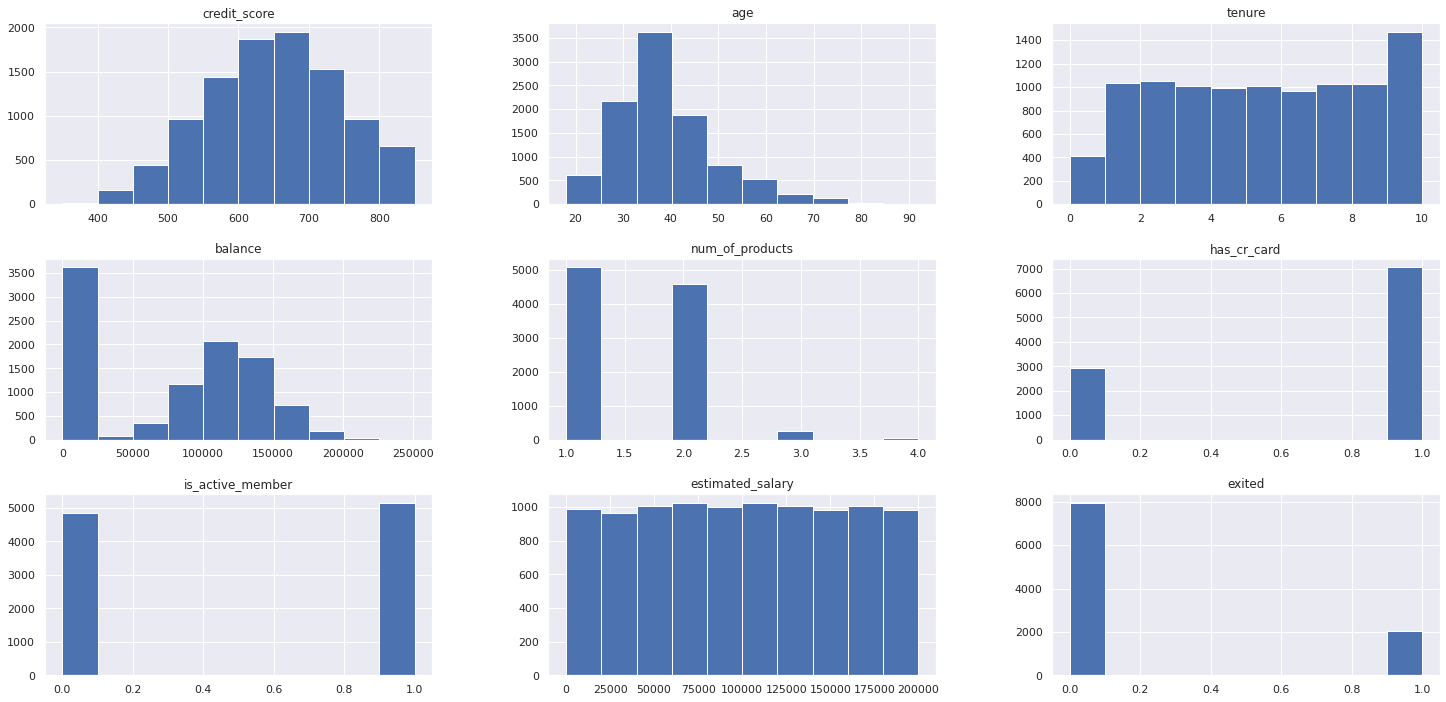

In [24]:
num_attributes.drop(columns=['customer_id']).hist();

### 4.1.3 Categorical Variables

In [25]:
# Customers that churn
aux1 = df1[df1['exited'] == 0]

# Customers that don't churn
aux2 = df1[df1['exited'] == 1]

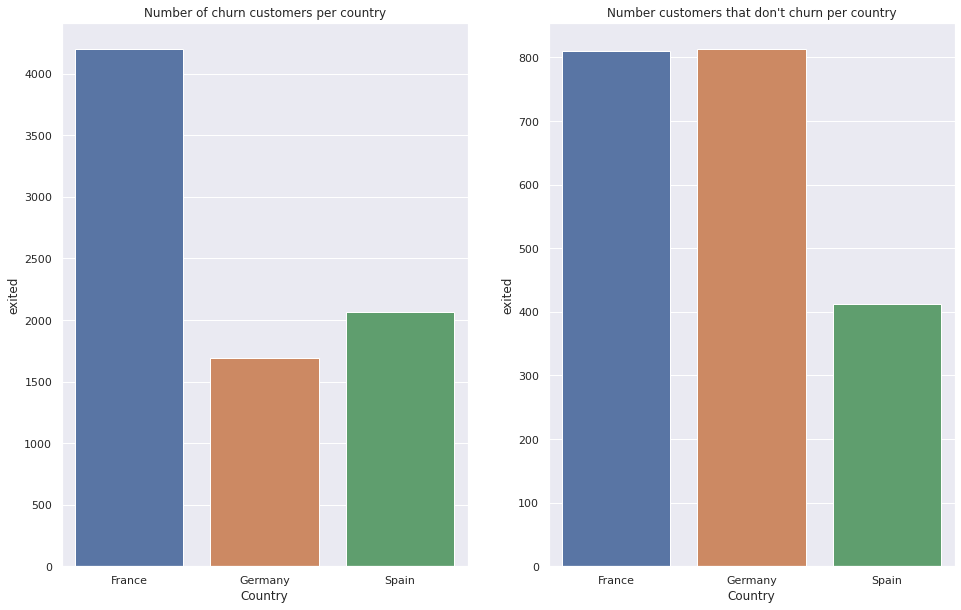

In [26]:
# Number of churn customers per country
churn_per_country = aux1[['geography', 'exited']].groupby('geography').count().reset_index()
plt.figure( figsize=(16,10) )
plt.subplot(1,2,1)
sb.barplot(x='geography',y='exited', data=churn_per_country);
plt.title('Number of churn customers per country');
plt.xlabel('Country');

# Number customers that don't churn per country
dont_churn_per_country = aux2[['geography', 'exited']].groupby('geography').count().reset_index()
plt.subplot(1,2,2)
sb.barplot(x='geography',y='exited', data=dont_churn_per_country);
plt.title("Number customers that don't churn per country");
plt.xlabel('Country');

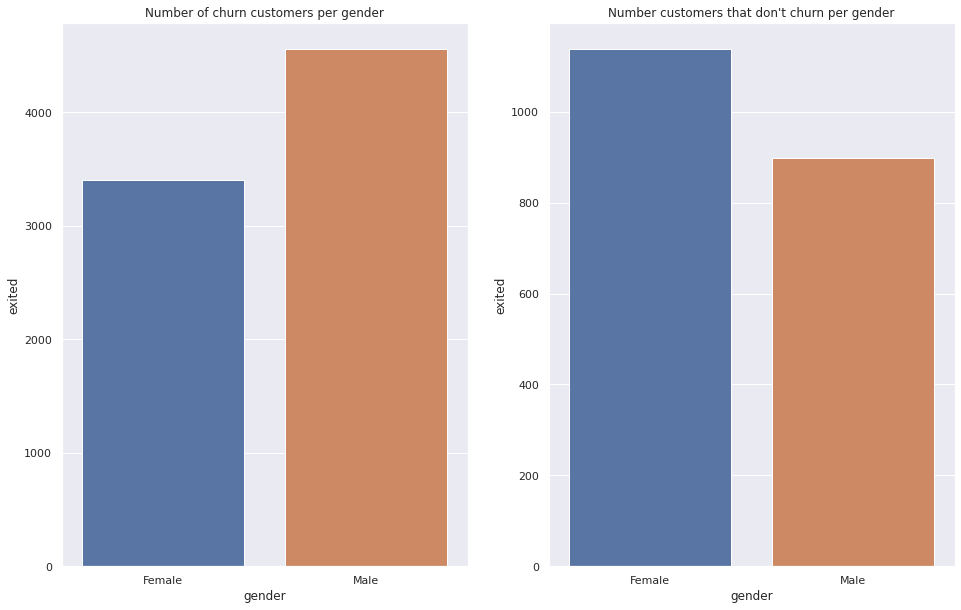

In [27]:
# Number of churn customers per gender
churn_per_gender = aux1[['gender', 'exited']].groupby('gender').count().reset_index()
plt.figure( figsize=(16,10) )
plt.subplot(1,2,1)
sb.barplot(x='gender',y='exited', data=churn_per_gender);
plt.title('Number of churn customers per gender');

# Number customers that don't churn per gender
dont_churn_per_gender = aux2[['gender', 'exited']].groupby('gender').count().reset_index()
plt.subplot(1,2,2)
sb.barplot(x='gender',y='exited', data=dont_churn_per_gender);
plt.title("Number customers that don't churn per gender");

## 4.2 Bivariate Analysis

### H1 - Clientes com mais de 50 anos sempre renovam o contrato.

**Falso.** Quase metade dos clientes com mais de 50 anos não renovam o contrato.

In [28]:
aux1 = df4.loc[df4['age'] > 50 ]

pd.DataFrame({'Customers': aux1['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,698,563


In [29]:
# Customers ratio by age group
range_18_to_33 = df4[(df4['age'] >= 18) & (df4['age'] <= 33)]['exited'].value_counts()
range_34_to_49 = df4[(df4['age'] >= 34) & (df4['age'] <= 49)]['exited'].value_counts()
range_50_to_65 = df4[(df4['age'] >= 50) & (df4['age'] <= 65)]['exited'].value_counts()
range_66_to_81 = df4[(df4['age'] >= 66) & (df4['age'] <= 81)]['exited'].value_counts()
range_82_above = df4[df4['age'] >= 82]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Customers between 18 and 33 years old': range_18_to_33}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

aux4_2 = pd.DataFrame({'Customers between 34 and 49 years old': range_34_to_49}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

aux4_3 = pd.DataFrame({'Customers between 50 and 65 years old': range_50_to_65}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

aux4_4 = pd.DataFrame({'Customers between 66 and 81 years old': range_66_to_81}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

aux4_5 = pd.DataFrame({'Customers 82+ years old': range_82_above}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4), exited_ratio(aux4_5)] )

,Renewed,Exited,Exited Ratio
Customers between 18 and 33 years old,2975,257,0.0800
Customers between 34 and 49 years old,4227,1146,0.2130
Customers between 50 and 65 years old,532,599,0.5300
Customers between 66 and 81 years old,222,34,0.1330
Customers 82+ years old,7,1,0.1250


### H2 - Clientes com salário acima da média deveriam renovar o contrato.

**Falso.** Aproximadamente 21% dos clientes com salário acima da média não renovam o contrato.

In [30]:
mean_salary = df4['estimated_salary'].mean()

aux1 = df4[df4['estimated_salary'] > mean_salary]

pd.DataFrame({'Customers': aux1['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,3965,1042


In [31]:
# Customers ratio by salary group
salary_range_1 = df4[df4['estimated_salary'] < 61580]['exited'].value_counts()
salary_range_2 = df4[(df4['estimated_salary'] >= 61580) & (df4['estimated_salary'] <= 111580)]['exited'].value_counts()
salary_range_3 = df4[(df4['estimated_salary'] > 111580) & (df4['estimated_salary'] <= 161580)]['exited'].value_counts()
salary_range_4 = df4[df4['estimated_salary'] > 161580]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Salary less than 61580': salary_range_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Salary between 61580 and 111580': salary_range_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Salary between 111580 and 161580': salary_range_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Salary greater than 161580': salary_range_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Salary less than 61580,2436,609,0.2000
Salary between 61580 and 111580,2049,506,0.1980
Salary between 111580 and 161580,1973,505,0.2040
Salary greater than 161580,1505,417,0.2170


### H3 - Clientes com "Credit Score" acima da média deveriam renovar o contrato.

**Falso.** Aproximadamente 20% dos clientes com Credit Score acima da média não renovam o contrato.

In [32]:
mean_credit = df4['credit_score'].mean()

aux1 = df4[df4['credit_score'] > mean_credit]

pd.DataFrame({'Customers': aux1['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,4083,980


In [33]:
# Customers ratio by credit score group
credit_range_1 = df4[df4['credit_score'] < 500]['exited'].value_counts()
credit_range_2 = df4[(df4['credit_score'] >= 500) & (df4['credit_score'] <= 650)]['exited'].value_counts()
credit_range_3 = df4[(df4['credit_score'] > 650) & (df4['credit_score'] <= 800)]['exited'].value_counts()
credit_range_4 = df4[df4['credit_score'] > 800]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Credit Score less than 500': credit_range_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Credit Score between 500 and 650': credit_range_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Credit Score between 650 and 800': credit_range_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Credit Score greater than 800': credit_range_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Credit Score less than 500,482,150,0.2370
Credit Score between 500 and 650,3398,907,0.2110
Credit Score between 650 and 800,3565,853,0.1930
Credit Score greater than 800,518,127,0.1970


### H4 - Clientes com balanço acima da média deveriam renovar o contrato.

**Falso.** Aproximadamente 24% dos clientes com balanço acima da média não renovam o contrato.

In [34]:
mean_credit = df4['balance'].mean()

aux1 = df4[df4['balance'] > mean_credit]

pd.DataFrame({'Customers': aux1['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,4493,1426


In [35]:
# Customers ratio by balance group
balance_range_1 = df4[df4['balance'] < 62500]['exited'].value_counts()
balance_range_2 = df4[(df4['balance'] >= 62500) & (df4['balance'] <= 125000)]['exited'].value_counts()
balance_range_3 = df4[(df4['balance'] > 125000) & (df4['balance'] <= 187500)]['exited'].value_counts()
balance_range_4 = df4[df4['balance'] > 187500]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Balance less than 62500': balance_range_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Balance between 62500 and 125000': balance_range_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Balance between 125000 and 187500': balance_range_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Balance greater than 187500': balance_range_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Balance less than 62500,3260,551,0.1450
Balance between 62500 and 125000,2625,833,0.2410
Balance between 125000 and 187500,2024,618,0.2340
Balance greater than 187500,54,35,0.3930


### H5 - Clientes com cartão de crédito deveriam renovar o contrato.

**Falso.** Aproximadamente 20% dos clientes que possuem cartão de crédito não renovam o contrato.

In [36]:
pd.DataFrame({'Customers': df4[df4['has_cr_card'] == 1]['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,5631,1424


In [37]:
# Customers ratio that have credit card
aux4_1 = df4[(df4['has_cr_card'] == 1) & (df4['age'] >= 18) & (df4['age'] <= 33)]['exited'].value_counts()
aux4_2 = df4[(df4['has_cr_card'] == 1) & (df4['age'] >= 34) & (df4['age'] <= 49)]['exited'].value_counts()
aux4_3 = df4[(df4['has_cr_card'] == 1) & (df4['age'] >= 50) & (df4['age'] <= 65)]['exited'].value_counts()
aux4_4 = df4[(df4['has_cr_card'] == 1) & (df4['age'] > 65)]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Customers between 18 and 33 years old and has credit card': aux4_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Customers between 34 and 49 years old and has credit card': aux4_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Customers between 50 and 65 years old and has credit card': aux4_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Customers 65+ years old and has credit card': aux4_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Customers between 18 and 33 years old and has credit card,2118,183,0.0800
Customers between 34 and 49 years old and has credit card,2978,815,0.2150
Customers between 50 and 65 years old and has credit card,372,402,0.5190
Customers 65+ years old and has credit card,163,24,0.1280


In [38]:
# Customers ratio that don't have credit card
aux4_1 = df4[(df4['has_cr_card'] == 0) & (df4['age'] >= 18) & (df4['age'] <= 33)]['exited'].value_counts()
aux4_2 = df4[(df4['has_cr_card'] == 0) & (df4['age'] >= 34) & (df4['age'] <= 49)]['exited'].value_counts()
aux4_3 = df4[(df4['has_cr_card'] == 0) & (df4['age'] >= 50) & (df4['age'] <= 65)]['exited'].value_counts()
aux4_4 = df4[(df4['has_cr_card'] == 0) & (df4['age'] > 65)]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Customers between 18 and 33 years old and dont has credit card': aux4_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Customers between 34 and 49 years old and dont has credit card': aux4_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Customers between 50 and 65 years old and dont has credit card': aux4_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Customers 65+ years old and dont has credit card': aux4_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Customers between 18 and 33 years old and dont has credit card,857,74,0.0790
Customers between 34 and 49 years old and dont has credit card,1249,331,0.2090
Customers between 50 and 65 years old and dont has credit card,160,197,0.5520
Customers 65+ years old and dont has credit card,66,11,0.1430


### H6 - Clientes que compram mais produtos renovam o contrato.

**Falso.** Aproximadamente 85% dos clientes que compram mais produtos (2+ produtos) não renovam o contrato.

In [39]:
pd.DataFrame({'Customers': df4[df4['num_of_products'] > 2]['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Exited,Renewed
Customers,280,46


In [40]:
# Customers ratio by numbers of products buyed
aux4_1 = df4[df4['num_of_products'] == 1 ]['exited'].value_counts()
aux4_2 = df4[df4['num_of_products'] == 2 ]['exited'].value_counts()
aux4_3 = df4[df4['num_of_products'] == 3 ]['exited'].value_counts()
aux4_4 = df4[df4['num_of_products'] == 4 ]['exited'].value_counts()
aux4_4['Renewed'] = 0

aux4_1 = pd.DataFrame({'Customers that buy 1 product': aux4_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Customers that buy 2 product': aux4_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Customers that buy 3 product': aux4_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Customers that buy 4 product': aux4_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Customers that buy 1 product,3675,1409,0.2770
Customers that buy 2 product,4242,348,0.0760
Customers that buy 3 product,46,220,0.8270
Customers that buy 4 product,0,60,1.0000


### H7 - Clientes que permaneceram ativo por mais tempo tendem a renovar o contrato.

**Falso.** Aproximadamente 20% dos clientes que permaneceram ativos por 8+ anos não renovaram o contrato.

In [41]:
pd.DataFrame({'Customers': df4[df4['tenure'] >= 8]['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,1988,511


In [42]:
# Customers ratio that exited by tenure
aux4_1 = df4[df4['tenure'] <= 2 ]['exited'].value_counts()
aux4_2 = df4[(df4['tenure'] > 2) & (df4['tenure'] <= 4) ]['exited'].value_counts()
aux4_3 = df4[(df4['tenure'] > 4) & (df4['tenure'] <= 6) ]['exited'].value_counts()
aux4_4 = df4[(df4['tenure'] > 6) & (df4['tenure'] <= 8)]['exited'].value_counts()
aux4_5 = df4[df4['tenure'] > 8 ]['exited'].value_counts()

aux4_1 = pd.DataFrame({'Customers that remained active less than 2 years': aux4_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Customers that remained active between 2 and 4 years': aux4_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Customers that remained active between 4 and 6 years': aux4_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Customers that remained active between 6 and 8 years': aux4_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_5 = pd.DataFrame({'Customers that remained active greater than 8 years': aux4_5}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4), exited_ratio(aux4_5)] )

,Renewed,Exited,Exited Ratio
Customers that remained active less than 2 years,1968,528,0.2120
Customers that remained active between 2 and 4 years,1582,416,0.2080
Customers that remained active between 4 and 6 years,1574,405,0.2050
Customers that remained active between 6 and 8 years,1679,374,0.1820
Customers that remained active greater than 8 years,1160,314,0.2130


### H8 - Clientes que movimentaram a conta nos últimos 12 meses tendem a renovar o contrato.

**Verdadeiro.** Aproximadamente 86% dos clientes que movimentaram a conta nos últimos 12 meses renovaram o contrato

In [43]:
pd.DataFrame({'Customers': df4[df4['is_active_member'] == 1]['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Renewed,Exited
Customers,4416,735


### H9 - Clientes que compram pelo menos 3 vezes em média no ano tendem a renovar o contrato.

**Falso.** Aproximadamente 19% dos clientes que compram +3x em média no ano não renovam o contrato.

In [44]:
pd.DataFrame({'Customers': df4[df4['products_buyed_per_year'] >= 3]['exited'].value_counts()}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

,Exited,Renewed
Customers,29,7


In [45]:
# Customers ratio by numbers of products buyed per year
aux4_1 = df4[df4['products_buyed_per_year'] <= 1 ]['exited'].value_counts()
aux4_2 = df4[(df4['products_buyed_per_year'] > 1) & (df4['products_buyed_per_year'] <= 2) ]['exited'].value_counts()
aux4_3 = df4[(df4['products_buyed_per_year'] > 2) & (df4['products_buyed_per_year'] <= 3)]['exited'].value_counts()
aux4_4 = df4[df4['products_buyed_per_year'] > 3 ]['exited'].value_counts()
aux4_4['Renewed'] = 0

aux4_1 = pd.DataFrame({'Customers that bought an average between 0 and 1 product': aux4_1}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_2 = pd.DataFrame({'Customers that bought an average between 1 and 2 products': aux4_2}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_3 = pd.DataFrame({'Customers that bought an average between 2 and 3 products': aux4_3}).T.rename(columns={0: 'Renewed', 1: 'Exited'})
aux4_4 = pd.DataFrame({'Customers that bought an average more than 3 product': aux4_4}).T.rename(columns={0: 'Renewed', 1: 'Exited'})

pd.concat( [exited_ratio(aux4_1), exited_ratio(aux4_2), exited_ratio(aux4_3), exited_ratio(aux4_4)] )

,Renewed,Exited,Exited Ratio
Customers that bought an average between 0 and 1 product,7556,1937,0.2040
Customers that bought an average between 1 and 2 products,400,71,0.1510
Customers that bought an average between 2 and 3 products,7,25,0.7810
Customers that bought an average more than 3 product,0,4,1.0000


### 4.2.1 Hypothesis Resume

In [46]:
tab = [ ['Hipoteses', 'Conclusao', 'Relevancia' ],
        ['H1', 'Falso', 'Alta'],
        ['H2', 'Falso', 'Baixa'],
        ['H3', 'Falso', 'Baixa'],
        ['H4', 'Falso', 'Media'],
        ['H5', 'Falso', 'Media'],
        ['H6', 'Falso', 'Alta'],
        ['H7', 'Falso', 'Media'],
        ['H8', 'Verdadeira', 'Alta'],
        ['H9', 'Falso', 'Alta']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falso        Alta
H2           Falso        Baixa
H3           Falso        Baixa
H4           Falso        Media
H5           Falso        Media
H6           Falso        Alta
H7           Falso        Media
H8           Verdadeira   Alta
H9           Falso        Alta


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

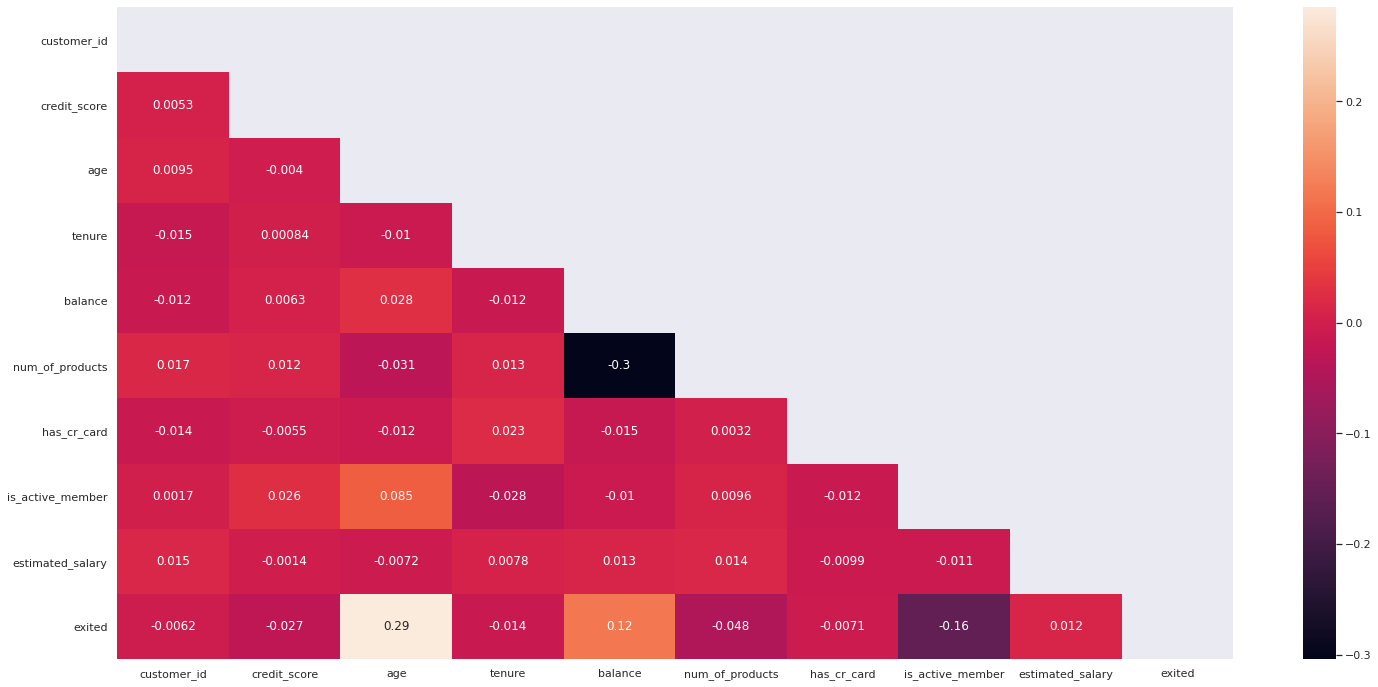

In [47]:
correlation = num_attributes.corr( method='pearson' )

# generate a mask for the upper triangle
mask = np.triu( np.ones_like(correlation, dtype=bool) )

sb.heatmap( correlation, annot=True, mask=mask );

### 4.3.2 Categorical Attributes

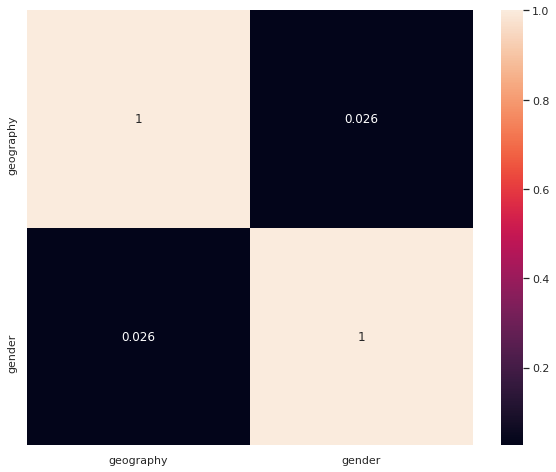

In [48]:
new_catg = cat_attributes.drop(columns=['surname'])

# calculate cramer V
catg1 = cramer_v(new_catg['geography'], new_catg['geography'])
catg2 = cramer_v(new_catg['geography'], new_catg['gender'])

catg3 = cramer_v(new_catg['gender'], new_catg['gender'])
catg4 = cramer_v(new_catg['gender'], new_catg['geography'])

result = pd.DataFrame( { 'geography': [catg1, catg2], 'gender': [catg4, catg3] } )
result = result.set_index( result.columns )

plt.figure( figsize=(10,8) )
sb.heatmap( result, annot=True );

# 5.0 DATA PREPARATION

In [49]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()

# credit_score
df5['credit_score'] = rs.fit_transform( df5[['credit_score']].values )

# age
df5['age'] = rs.fit_transform( df5[['age']].values )

# balance
df5['balance'] = mms.fit_transform( df5[['balance']].values )

# estimated_salary
df5['estimated_salary'] = mms.fit_transform( df5[['estimated_salary']].values )

## 5.3 Transformation

### 5.3.1 Encoding

In [51]:
# gender
df5['gender'] = df5['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# geography
le = LabelEncoder()
df5['geography'] = le.fit_transform( df5['geography'] )

## 5.4 SMOTE - Synthetic Minority Oversampling Technique

In [52]:
oversample = SMOTE()

X_np = df5.loc[:, df5.columns != 'exited'].values
y_np = df5['exited'].values

X, y = oversample.fit_resample(X_np, y_np)

In [53]:
# check oversample results
counter = Counter(y)
for k, v in counter.items():
    dist = v / len(y) * 100
    print(f'Class={k}, n={v} ({round(dist,2)})%')

Class=1, n=7963 (50.0)%
Class=0, n=7963 (50.0)%


# 6.0 FEATURE SELECTION

In [54]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test

In [55]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.30, random_state=34)

# number of rows and columns from the sets
print (f'> Spliting dataset into train and test:\n')
print ('X_train: numbers of rows and columns: {}'.format(X_train_np.shape))
print ('X_test: numbers of rows and columns: {}'.format(X_test_np.shape))
print ('y_train: numbers of rows and columns: {}'.format(y_train_np.shape))
print ('y_test: numbers of rows and columns: {}\n'.format(y_test_np.shape))

> Spliting dataset into train and test:

X_train: numbers of rows and columns: (11148, 11)
X_test: numbers of rows and columns: (4778, 11)
y_train: numbers of rows and columns: (11148,)
y_test: numbers of rows and columns: (4778,)



## 6.2 Boruta as Feature Selector

In [56]:
# classifier to use on Boruta Feature Selector
#rf = RandomForestClassifier()

#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=34 ).fit( X_train_np, y_train_np )

### 6.2.1 Best Features from Boruta

In [57]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = df6.loc[:, df6.columns != 'exited']
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# columns not selected from boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

## 6.3. Manual Features Selection

In [58]:
cols_selected_boruta_full = ['age', 'balance', 'num_of_products', 'is_active_member', 'credit_score', 'estimated_salary', 'products_buyed_per_year']

# 7.0 MACHINE LEARNING MODELLING

In [59]:
X_train_np = filter_columns_in_numpy(X_train_np, cols_selected_boruta_full)
X_test_np = filter_columns_in_numpy(X_test_np, cols_selected_boruta_full)

## 7.1 Baseline Model

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
Baseline Model,0.4960,0.0000,1.0000,0.0000,0.5000,0.0000


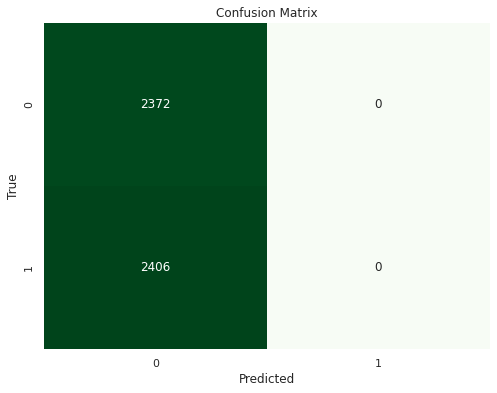

In [119]:
dc = DummyClassifier()

dc.fit(X_train_np, y_train_np)
y_hat = dc.predict(X_test_np)

bm_result = algorithm_performance('Baseline Model', y_test_np, y_hat)
bm_result

## 7.2 KNN

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
KNN,0.7960,0.8190,0.7730,0.8020,0.7960,0.5930


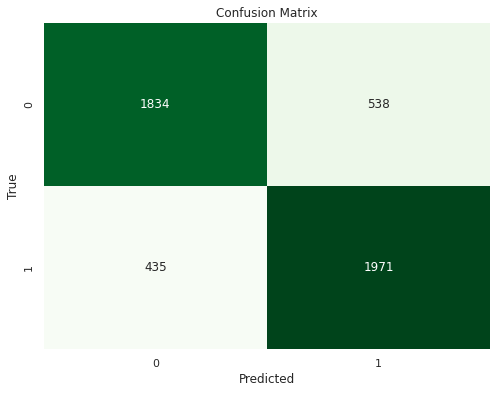

In [124]:
knn = KNeighborsClassifier()

knn.fit(X_train_np, y_train_np)
y_hat = knn.predict(X_test_np)

knn_result = algorithm_performance('KNN', y_test_np, y_hat)
knn_result

### 7.2.1 KNN - Cross Validation

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
KNN,0.7960,0.8270,0.7660,0.8020,0.7960,0.5930


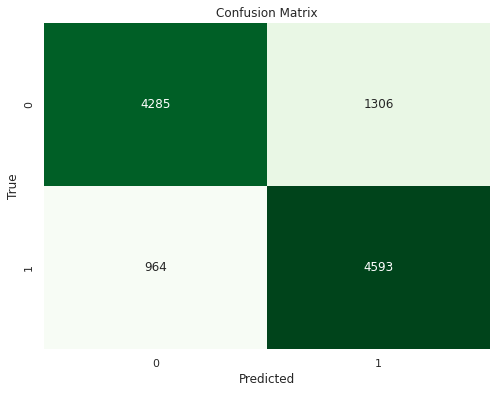

In [136]:
y_hat = cross_val_predict(knn, X_train_np, y_train_np, cv=10)
knn_result_cv = algorithm_performance('KNN',y_train_np, y_hat)
knn_result_cv

## 7.3 SVM

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
SVM,0.7610,0.7140,0.8080,0.7510,0.7610,0.5220


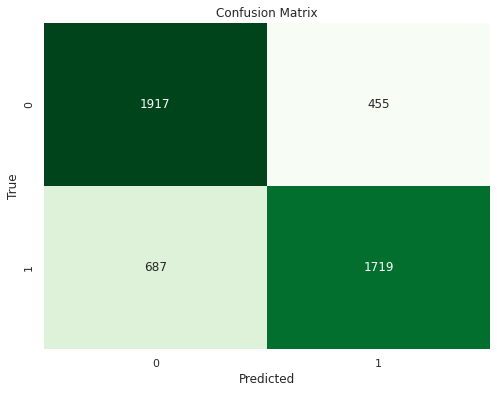

In [126]:
svm = SVC(gamma='auto')

svm.fit(X_train_np, y_train_np)
y_hat = svm.predict(X_test_np)

svm_result = algorithm_performance('SVM', y_test_np, y_hat)
svm_result

### 7.3.1 SVM - Cross Validation

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
SVM,0.7760,0.7370,0.8150,0.7660,0.7760,0.5510


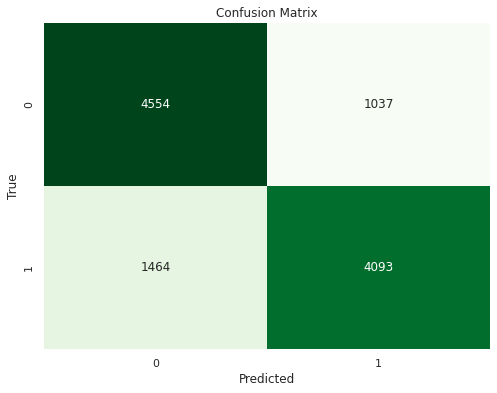

In [137]:
y_hat = cross_val_predict(svm, X_train_np, y_train_np, cv=10)
svm_result_cv = algorithm_performance('SVM', y_train_np, y_hat)
svm_result_cv

## 7.4 XGBoost

/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:46:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
XGBoost,0.8890,0.8620,0.9180,0.8870,0.8900,0.7790


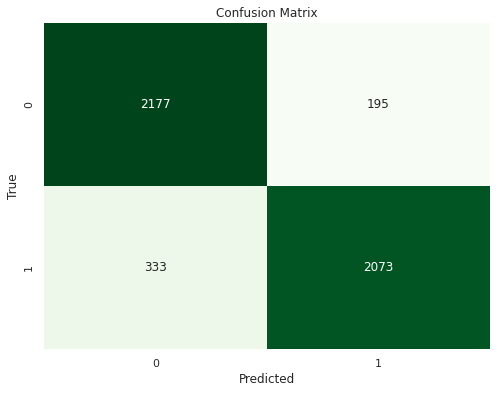

In [128]:
xgb = XGBClassifier(random_state=34)

xgb.fit(np.array(X_train_np), np.array(y_train_np))
y_hat = xgb.predict(np.array(X_test_np))

xgb_result = algorithm_performance('XGBoost', y_test_np, y_hat)
xgb_result

### 7.4.1 XGBoost - Cross Validation

/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/media/ronaldo/HD/Python Projects/Projetos de Portifólio/TopBank Churn Prediction/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
XGBoost,0.8880,0.8650,0.9110,0.8850,0.8880,0.7760


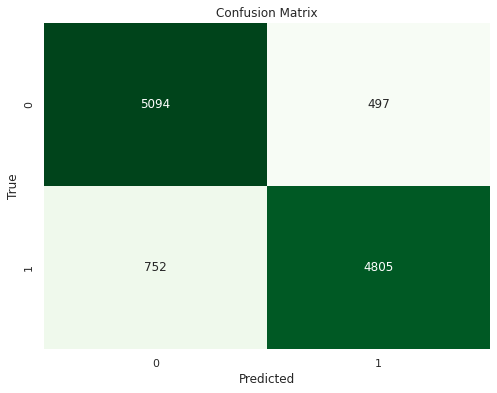

In [138]:
y_hat = cross_val_predict(xgb, np.array(X_train_np), np.array(y_train_np), cv=10)
xgb_result_cv = algorithm_performance('XGBoost', np.array(y_train_np), y_hat)
xgb_result_cv

## 7.5 Random Forest

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
Random Forest,0.8640,0.8470,0.8810,0.8630,0.8640,0.7280


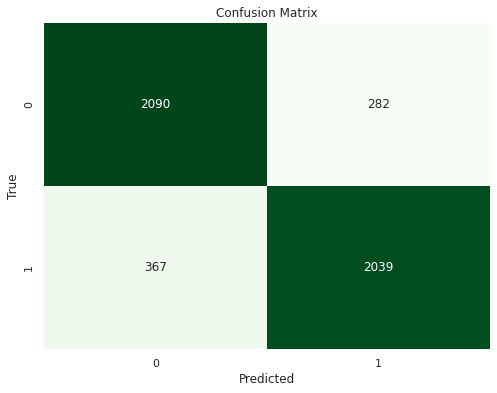

In [131]:
rf = RandomForestClassifier()

rf.fit(np.array(X_train_np), np.array(y_train_np))
y_hat = rf.predict(np.array(X_test_np))

rf_result = algorithm_performance('Random Forest', y_test_np, y_hat)
rf_result

### 7.5.1 Random Forest - Cross Validation

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
Random Forest,0.8640,0.8490,0.8790,0.8620,0.8640,0.7280


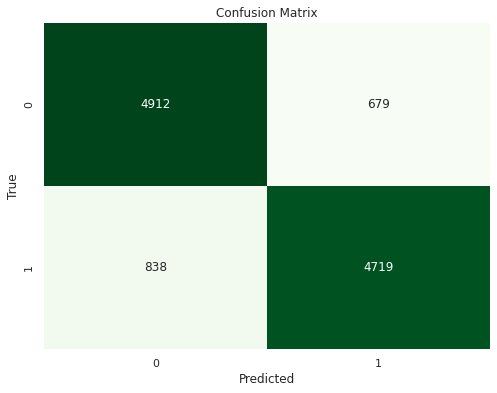

In [139]:
y_hat = cross_val_predict(rf, np.array(X_train_np), np.array(y_train_np), cv=10)
rf_result_cv = algorithm_performance('Random Forest', np.array(y_train_np), y_hat)
rf_result_cv

## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [134]:
modelling_result = pd.concat( [bm_result, knn_result, svm_result, xgb_result, rf_result] )
modelling_result.sort_values( 'Accuracy' , ascending=False)

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
XGBoost,0.8890,0.8620,0.9180,0.8870,0.8900,0.7790
Random Forest,0.8640,0.8470,0.8810,0.8630,0.8640,0.7280
KNN,0.7960,0.8190,0.7730,0.8020,0.7960,0.5930
SVM,0.7610,0.7140,0.8080,0.7510,0.7610,0.5220
Baseline Model,0.4960,0.0000,1.0000,0.0000,0.5000,0.0000


### 7.6.2 Real Performance - Cross Validation

In [140]:
modelling_result = pd.concat( [knn_result_cv, svm_result_cv, xgb_result_cv, rf_result_cv] )
modelling_result.sort_values( 'Accuracy' , ascending=False)

,Accuracy,Sensitivity,Specificity,F1,ROC_AUC,Kappa
XGBoost,0.8880,0.8650,0.9110,0.8850,0.8880,0.7760
Random Forest,0.8640,0.8490,0.8790,0.8620,0.8640,0.7280
KNN,0.7960,0.8270,0.7660,0.8020,0.7960,0.5930
SVM,0.7760,0.7370,0.8150,0.7660,0.7760,0.5510
